In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import preprocessing as proc

from sklearn.model_selection import cross_validate, GridSearchCV, StratifiedKFold
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, LabelEncoder, OrdinalEncoder
from sklearn.ensemble import RandomForestClassifier, HistGradientBoostingClassifier
from imblearn.pipeline import Pipeline
from imblearn.over_sampling import RandomOverSampler

pd.pandas.set_option('display.max_columns', None)

In [4]:
df = pd.read_csv('carclaims.csv')
print(df.shape)
df.head()

(15420, 33)


,Month,WeekOfMonth,DayOfWeek,Make,AccidentArea,DayOfWeekClaimed,MonthClaimed,WeekOfMonthClaimed,Sex,MaritalStatus,Age,Fault,PolicyType,VehicleCategory,VehiclePrice,PolicyNumber,RepNumber,Deductible,DriverRating,Days:Policy-Accident,Days:Policy-Claim,PastNumberOfClaims,AgeOfVehicle,AgeOfPolicyHolder,PoliceReportFiled,WitnessPresent,AgentType,NumberOfSuppliments,AddressChange-Claim,NumberOfCars,Year,BasePolicy,FraudFound
0,Dec,5,Wednesday,Honda,Urban,Tuesday,Jan,1,Female,Single,21,Policy Holder,Sport - Liability,Sport,"more than 69,000",1,12,300,1,more than 30,more than 30,none,3 years,26 to 30,No,No,External,none,1 year,3 to 4,1994,Liability,No
1,Jan,3,Wednesday,Honda,Urban,Monday,Jan,4,Male,Single,34,Policy Holder,Sport - Collision,Sport,"more than 69,000",2,15,400,4,more than 30,more than 30,none,6 years,31 to 35,Yes,No,External,none,no change,1 vehicle,1994,Collision,No
2,Oct,5,Friday,Honda,Urban,Thursday,Nov,2,Male,Married,47,Policy Holder,Sport - Collision,Sport,"more than 69,000",3,7,400,3,more than 30,more than 30,1,7 years,41 to 50,No,No,External,none,no change,1 vehicle,1994,Collision,No
3,Jun,2,Saturday,Toyota,Rural,Friday,Jul,1,Male,Married,65,Third Party,Sedan - Liability,Sport,"20,000 to 29,000",4,4,400,2,more than 30,more than 30,1,more than 7,51 to 65,Yes,No,External,more than 5,no change,1 vehicle,1994,Liability,No
4,Jan,5,Monday,Honda,Urban,Tuesday,Feb,2,Female,Single,27,Third Party,Sport - Collision,Sport,"more than 69,000",5,3,400,1,more than 30,more than 30,none,5 years,31 to 35,No,No,External,none,no change,1 vehicle,1994,Collision,No


In [5]:
X = df.drop(['PolicyNumber', 'FraudFound'], axis=1)
y = df['FraudFound']
print(X.shape, y.shape)
X.head()

(15420, 31) (15420,)


,Month,WeekOfMonth,DayOfWeek,Make,AccidentArea,DayOfWeekClaimed,MonthClaimed,WeekOfMonthClaimed,Sex,MaritalStatus,Age,Fault,PolicyType,VehicleCategory,VehiclePrice,RepNumber,Deductible,DriverRating,Days:Policy-Accident,Days:Policy-Claim,PastNumberOfClaims,AgeOfVehicle,AgeOfPolicyHolder,PoliceReportFiled,WitnessPresent,AgentType,NumberOfSuppliments,AddressChange-Claim,NumberOfCars,Year,BasePolicy
0,Dec,5,Wednesday,Honda,Urban,Tuesday,Jan,1,Female,Single,21,Policy Holder,Sport - Liability,Sport,"more than 69,000",12,300,1,more than 30,more than 30,none,3 years,26 to 30,No,No,External,none,1 year,3 to 4,1994,Liability
1,Jan,3,Wednesday,Honda,Urban,Monday,Jan,4,Male,Single,34,Policy Holder,Sport - Collision,Sport,"more than 69,000",15,400,4,more than 30,more than 30,none,6 years,31 to 35,Yes,No,External,none,no change,1 vehicle,1994,Collision
2,Oct,5,Friday,Honda,Urban,Thursday,Nov,2,Male,Married,47,Policy Holder,Sport - Collision,Sport,"more than 69,000",7,400,3,more than 30,more than 30,1,7 years,41 to 50,No,No,External,none,no change,1 vehicle,1994,Collision
3,Jun,2,Saturday,Toyota,Rural,Friday,Jul,1,Male,Married,65,Third Party,Sedan - Liability,Sport,"20,000 to 29,000",4,400,2,more than 30,more than 30,1,more than 7,51 to 65,Yes,No,External,more than 5,no change,1 vehicle,1994,Liability
4,Jan,5,Monday,Honda,Urban,Tuesday,Feb,2,Female,Single,27,Third Party,Sport - Collision,Sport,"more than 69,000",3,400,1,more than 30,more than 30,none,5 years,31 to 35,No,No,External,none,no change,1 vehicle,1994,Collision


In [6]:
label_encode = LabelEncoder()
y = label_encode.fit_transform(y)

In [7]:
TEMP_VAR = ['Month', 'MonthClaimed', 'DayOfWeek']

NUM_VAR = ['DriverRating']

ONE_HOT_CAT_VAR = ['Make', 'PolicyType', 'MaritalStatus', 'VehicleCategory',
                       'BasePolicy', 'AgentType', 'WitnessPresent', 
                       'PoliceReportFiled', 'Fault', 'Sex', 'AccidentArea']

ORDINAL_CAT_VAR = ['NumberOfCars', 'Days:Policy-Claim']

NUM_CAR_VAR = ['NumberOfCars']
DAYS_CLAIM_VAR = ['Days:Policy-Claim']

MONTH_MAP = {'Jan': 1, 'Feb': 2, 'Mar': 3, 'Apr': 4, 'May': 5, 'Jun': 6, 'Jul': 7, 'Aug': 8, 'Sep': 9, 'Oct': 10, 'Nov': 11, 'Dec': 12}
DAY_MAP = {'Sunday': 6, 'Monday': 0, 'Tuesday': 1, 'Wednesday': 2, 'Thursday': 3, 'Friday': 4, 'Saturday': 5}
NUM_CAR_MAP = {'1 vehicle': 1, '2 vehicles': 2, '3 to 4': 3, '5 to 8': 4, 'more than 8': 5}
DAYS_CLAIM_MAP = {'none':1, '8 to 15': 2, '15 to 30': 3, 'more than 30': 4}

In [8]:
FEATURES = [
    'Make',
    'PolicyType',
    'BasePolicy',
    'MaritalStatus',
    'Sex',
    'VehicleCategory',
    'AgentType',
    'WitnessPresent',
    'PoliceReportFiled',
    'AccidentArea',
    'NumberOfCars',
    'Fault',
    'Month',
    'MonthClaimed',
    'DayOfWeek',
    'Days:Policy-Claim',
    'DriverRating']

In [9]:
X = X[FEATURES]
X.head()

,Make,PolicyType,BasePolicy,MaritalStatus,Sex,VehicleCategory,AgentType,WitnessPresent,PoliceReportFiled,AccidentArea,NumberOfCars,Fault,Month,MonthClaimed,DayOfWeek,Days:Policy-Claim,DriverRating
0,Honda,Sport - Liability,Liability,Single,Female,Sport,External,No,No,Urban,3 to 4,Policy Holder,Dec,Jan,Wednesday,more than 30,1
1,Honda,Sport - Collision,Collision,Single,Male,Sport,External,No,Yes,Urban,1 vehicle,Policy Holder,Jan,Jan,Wednesday,more than 30,4
2,Honda,Sport - Collision,Collision,Married,Male,Sport,External,No,No,Urban,1 vehicle,Policy Holder,Oct,Nov,Friday,more than 30,3
3,Toyota,Sedan - Liability,Liability,Married,Male,Sport,External,No,Yes,Rural,1 vehicle,Third Party,Jun,Jul,Saturday,more than 30,2
4,Honda,Sport - Collision,Collision,Single,Female,Sport,External,No,No,Urban,1 vehicle,Third Party,Jan,Feb,Monday,more than 30,1


[Comparing Random Forests and Histogram Gradient Boosting models](https://scikit-learn.org/stable/auto_examples/ensemble/plot_forest_hist_grad_boosting_comparison.html#sphx-glr-auto-examples-ensemble-plot-forest-hist-grad-boosting-comparison-py): Between a Random Forest and a Gradient Boosting Machine, GBMs always tend to outperform random forest, having a faster training time but with higher R2 test scores. Random forests have faster prediction time but does not outperform in terms of test scores. 

#### Random Forest classifier

In [10]:
# column transformers for Random Forest (One Hot Encoding + Scaling)
cat_transform = ColumnTransformer(
    transformers=[
        ('cat', OneHotEncoder(sparse_output=False, handle_unknown='infrequent_if_exist'), ONE_HOT_CAT_VAR)
    ], remainder='passthrough'
).set_output(transform='pandas')

"""scale_transform = ColumnTransformer(
    transformers=[
        ('scale', MinMaxScaler(), ['remainder__' + i for i in NUM_VAR + ORDINAL_CAT_VAR])
    ], remainder='passthrough'
).set_output(transform='pandas')"""

"scale_transform = ColumnTransformer(\n    transformers=[\n        ('scale', MinMaxScaler(), ['remainder__' + i for i in NUM_VAR + ORDINAL_CAT_VAR])\n    ], remainder='passthrough'\n).set_output(transform='pandas')"

In [11]:
# Random Forest pipeline
# clean -> map -> cos/sin -> drop -> onehot -> scale -> sampling -> classify
rf_pipeline = Pipeline([
    ('clean', proc.CleanTransform(variable=TEMP_VAR)),
    ('map_month', proc.MapTransform(variable=TEMP_VAR[:2], mappings=MONTH_MAP)),
    ('map_day', proc.MapTransform(variable=[TEMP_VAR[-1]], mappings=DAY_MAP)),
    ('map_num', proc.MapTransform(variable=NUM_CAR_VAR, mappings=NUM_CAR_MAP)),
    ('map_claim', proc.MapTransform(variable=DAYS_CLAIM_VAR, mappings=DAYS_CLAIM_MAP)),
    ('cos_sin', proc.CoSineTransform(variable=TEMP_VAR)),
    ('drop', proc.DropTransform(variable=TEMP_VAR)),
    ('one_hot', cat_transform),
    ('sampler', RandomOverSampler(random_state=42)),
    ('classifier', RandomForestClassifier(random_state=42))
])

In [12]:
# hyperparameters for Random Forest
rf_param_grid = {
    'classifier__n_estimators': [100, 200, 300],
    'classifier__criterion': ['gini', 'entropy', 'log_loss']
}

#### HistGradientBoosting classifier

In [13]:
# specify categories for OrdinalEncoder since OrdinalEncoder does not ignore unknown categories
# unknown categories are caused by the K-fold cross validations
make = list(X['Make'].unique())
policy_type = list(X['PolicyType'].unique())
marital = list(X['MaritalStatus'].unique())
vehicle_cat = list(X['VehicleCategory'].unique())
basepolicy = list(X['BasePolicy'].unique())
agent = list(X['AgentType'].unique())
witness = list(X['WitnessPresent'].unique())
police = list(X['PoliceReportFiled'].unique())
fault = list(X['Fault'].unique())
sex = list(X['Sex'].unique())
accident = list(X['AccidentArea'].unique())

In [14]:
# column transformer for HistGradientBooster
ordinal_transform = ColumnTransformer(
    transformers=[
        ('int_enc', OrdinalEncoder(
            categories=[
                make, policy_type, marital, vehicle_cat, basepolicy, agent, witness, police, fault, sex, accident
            ]
            ), ONE_HOT_CAT_VAR)
    ], remainder='passthrough'
).set_output(transform='pandas')

In [15]:
# HistGradientBooster pipeline
# clean -> map -> cos/sin -> drop -> sampling -> ordinal -> classify
hgb_pipeline = Pipeline([
    ('clean', proc.CleanTransform(variable=TEMP_VAR)),
    ('map_month', proc.MapTransform(variable=TEMP_VAR[:2], mappings=MONTH_MAP)),
    ('map_day', proc.MapTransform(variable=[TEMP_VAR[-1]], mappings=DAY_MAP)),
    ('map_num', proc.MapTransform(variable=NUM_CAR_VAR, mappings=NUM_CAR_MAP)),
    ('map_claim', proc.MapTransform(variable=DAYS_CLAIM_VAR, mappings=DAYS_CLAIM_MAP)),
    ('cos_sin', proc.CoSineTransform(variable=TEMP_VAR)),
    ('drop', proc.DropTransform(variable=TEMP_VAR)),
    ('encode', ordinal_transform),
    ('sampler', RandomOverSampler(random_state=42)),
    ('classifier', HistGradientBoostingClassifier(random_state=42))
])

In [16]:
# hyperparameters for HistGradientBooster
hgb_param_grid = {
    'classifier__learning_rate': [0.1, 0.01, 0.05],
    'classifier__max_iter': [100, 200],
    'classifier__l2_regularization': [0, 0.001, 0.005]
}

In [17]:
# scoring metric chosen for grid search
scoring = {
    'accuracy': 'accuracy',
}

#### K-Fold Cross Validation

In [18]:
# K-Fold cross validator
outer_loop = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

#### GridSearch

In [19]:
# exhaustive search for each estimator
rf_grid_loop = GridSearchCV(rf_pipeline, rf_param_grid, cv=5, scoring=scoring, refit='accuracy', n_jobs=-1)
hgb_grid_loop = GridSearchCV(hgb_pipeline, hgb_param_grid, cv=5, scoring=scoring, refit='accuracy', n_jobs=-1)

In [20]:
# best parameters for Random Forest
rf_grid_loop.fit(X, y)
print(rf_grid_loop.best_params_)

{'classifier__criterion': 'gini', 'classifier__n_estimators': 300}


In [21]:
# best parameters for HistGradientBooster
hgb_grid_loop.fit(X,y)
print(hgb_grid_loop.best_params_)

{'classifier__l2_regularization': 0, 'classifier__learning_rate': 0.1, 'classifier__max_iter': 200}


In [22]:
rf_score = cross_validate(rf_grid_loop, X=X, y=y, cv=outer_loop, scoring=scoring, error_score='raise', n_jobs=-1)
rf_score

{'fit_time': array([193.81578612, 195.94027066, 192.74452662, 165.57539582,
        151.97632384]),
 'score_time': array([0.12102866, 0.1540339 , 0.07102036, 0.53812194, 0.23505497]),
 'test_accuracy': array([0.9192607 , 0.91407263, 0.91666667, 0.91309987, 0.91083009])}

In [23]:
hgb_score = cross_validate(hgb_grid_loop, X=X, y=y, cv=outer_loop, scoring=scoring, error_score='raise', n_jobs=-1)
hgb_score

{'fit_time': array([160.08814788, 161.30344439, 160.86832762, 161.17141724,
        157.63260317]),
 'score_time': array([0.07202148, 0.05801344, 0.06601596, 0.07101583, 0.10902452]),
 'test_accuracy': array([0.78728923, 0.80155642, 0.79182879, 0.77918288, 0.78858625])}

In [24]:
results = {
    'rf': {'fit_time': rf_score['fit_time'], 'score_time':rf_score['score_time'], 'accuracy':rf_score['test_accuracy']},
    'hgb': {'fit_time': hgb_score['fit_time'], 'score_time':hgb_score['score_time'], 'accuracy':hgb_score['test_accuracy']},
}

#### Fit Time vs Accuracy

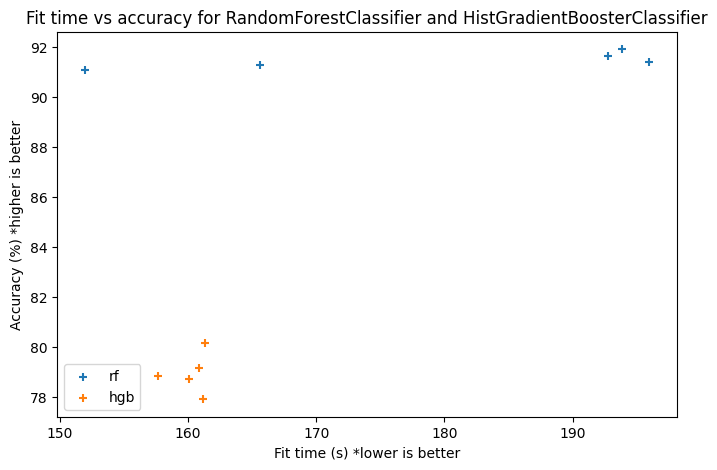

In [25]:
plt.figure(figsize=(8, 5))

for estimator, metrics in results.items():
    fit_time = metrics['fit_time']
    score_time = metrics['score_time']
    accuracy = metrics['accuracy'] * 100
    plt.scatter(fit_time, accuracy, label=estimator, marker='+')

plt.title('Fit time vs accuracy for RandomForestClassifier and HistGradientBoosterClassifier')
plt.xlabel('Fit time (s) *lower is better')
plt.ylabel('Accuracy (%) *higher is better')
plt.legend()
plt.show()


#### Scoring time

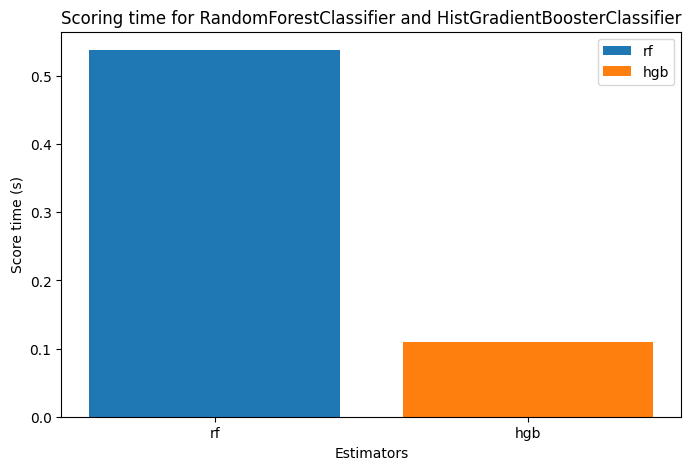

In [26]:
plt.figure(figsize=(8, 5))

for estimator, metrics in results.items():
    score_time = metrics['score_time']
    plt.bar(estimator, score_time, label=estimator)

plt.title('Scoring time for RandomForestClassifier and HistGradientBoosterClassifier')
plt.xlabel('Estimators')
plt.ylabel('Score time (s)')
plt.legend()
plt.show()

Random Forest costs more compute time to train, has slower prediction time, but performs better in terms of accuracy than HistGradientBoosterClassifier in this case.